In [157]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

In [158]:
#hyperparameters and blank image and label generation
N = 4000
size = 64
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [159]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_blob_img(length=size, big = True, big_blob_size=8, big_blob_range=2)
    elif labels[i] == 1:
        x = generator.generate_blob_img(length=size, big = False)
    imgs[:,:,i] = x

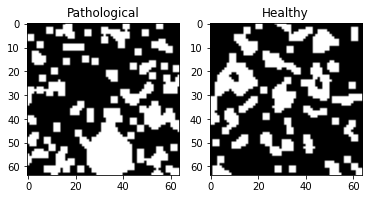

In [160]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");

In [161]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(4000, 64, 64, 1)

In [162]:
# Model hyperparameters
num_classes = 2
input_shape = (size, size, 1)
batch_size = 64
epochs = 20
conv_size=(12,12)
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [163]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 12544)             0         
                                                                 
 dropout_2 (Dropout)         (None, 12544)            

In [164]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
38/38 [==============================] - 4s 100ms/step - loss: 0.7025 - accuracy: 0.4963 - val_loss: 0.6945 - val_accuracy: 0.4739
Epoch 2/20
38/38 [==============================] - 4s 99ms/step - loss: 0.6764 - accuracy: 0.5929 - val_loss: 0.6766 - val_accuracy: 0.5485
Epoch 3/20
38/38 [==============================] - 4s 101ms/step - loss: 0.6361 - accuracy: 0.6343 - val_loss: 0.6246 - val_accuracy: 0.7164
Epoch 4/20
38/38 [==============================] - 4s 100ms/step - loss: 0.5349 - accuracy: 0.7562 - val_loss: 0.5291 - val_accuracy: 0.7612
Epoch 5/20
38/38 [==============================] - 4s 99ms/step - loss: 0.4004 - accuracy: 0.8383 - val_loss: 0.4274 - val_accuracy: 0.8060
Epoch 6/20
38/38 [==============================] - 4s 99ms/step - loss: 0.3089 - accuracy: 0.8864 - val_loss: 0.3672 - val_accuracy: 0.8507
Epoch 7/20
38/38 [==============================] - 4s 101ms/step - loss: 0.2488 - accuracy: 0.9138 - val_loss: 0.3349 - val_accuracy: 0.8545
Epoch 8/2

In [165]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.24340564012527466
Test accuracy: 0.9106060862541199
42/42 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

Pathological       0.97      0.85      0.91       691
     Healthy       0.86      0.97      0.91       629

    accuracy                           0.91      1320
   macro avg       0.92      0.91      0.91      1320
weighted avg       0.92      0.91      0.91      1320



In [166]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


42/42 [==============================] - 1s 15ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

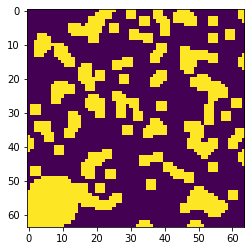

In [167]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
plt.imshow(img)

In [168]:
#choose explainability options
explain_picker = widgets.SelectMultiple(
    options=['GradCAM', 'Single Blob Occlusion', 'Patch Occlusion', 'Overlapping Patch Occlusion'],
    value=['GradCAM'],
    #rows=10,
    description='Methods',
    disabled=False
)

display(explain_picker)

SelectMultiple(description='Methods', index=(0,), options=('GradCAM', 'Single Blob Occlusion', 'Patch Occlusio…

In [171]:
%%capture
heatmaps = []

for method in explain_picker.value:
    if method == 'GradCAM':
        heatmaps.append(explainabilityModels.make_gradcam_heatmap(img, model, -5))
    elif method == 'Single Blob Occlusion':
        heatmaps.append(explainabilityModels.single_blob_occlusion(img, label_picker.value, model=model)[0])
    elif method == 'Patch Occlusion':
        heatmaps.append(explainabilityModels.occlusion_map(img, label_picker.value, patch_size = 8, model=model))
    elif method == 'Overlapping Patch Occlusion':
        heatmaps.append(explainabilityModels.overlapping_occlusion_map(img, label_picker.value, patch_size=8, step_size = 4, model=model))
        

0
1
2
3


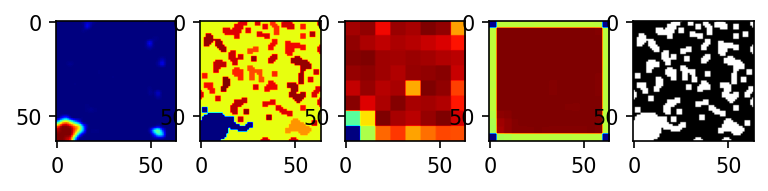

In [172]:
fig, ax = plt.subplots(1, len(heatmaps)+1)
fig.set_dpi(150)
fig.tight_layout
for idx, map in enumerate(heatmaps):
    print(idx)
    ax[idx].imshow(map, cmap=plt.cm.jet)

ax[-1].imshow(img, cmap=plt.cm.gray)